# "[경영팀] 중심 사례 연구 분석"
> "딥러닝 컨설턴트로 일하고 있으며 토론토 시내의 병원에 고용되어 폐병을 발견하고 분류하는 과정을 자동화하여
비용과 시간을 줄이는 일을 맡았다고 가정한다."

- toc:true- branch: master
- badges: true
- comments: true
- author: Jihyeon
- categories: [business, data science]

# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning 
  </td></tr>
</table>


## 🚣‍♂️ 목적
* 흉부 엑스레이 데이터로 환자의 질병 유형을 진단

## 💡 성과
1. 1분 내로 질병을 발견하고 분류할 수 있는 모델
2. 네 가지 종류에 속하는 133개의 이미지를 분류
3. CNN에 대한 직관적으로 이해할 수 있음
4. matplotlib, seaborn 시각화 라이브러리
5. 전이학습에 관해 직관적으로 이해할 수 있음
6. ResNet 만들고 훈련시키기
7. 분류 데스트 수행, 모델 평가, 혼동행렬 및 분류 보고서


# TASK #2: IMPORT LIBRARIES AND DATASET

In [1]:
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [11]:
from zipfile import ZipFile

In [12]:
with ZipFile('data.zip', 'r') as z:
   # Extract all the contents of zip file in current directory
   z.extractall()

In [13]:
X_Ray_Directory = 'data/Dataset/'

In [15]:
os.listdir(X_Ray_Directory)

['2', '3', '0', '1']

In [16]:
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [17]:
train_generator = image_generator.flow_from_directory(batch_size=40,
    directory=X_Ray_Directory, shuffle=True, target_size=(256, 256),
    class_mode='categorical', subset='training')

Found 428 images belonging to 4 classes.


In [18]:
validation_generator = image_generator.flow_from_directory(batch_size=40,
    directory=X_Ray_Directory, shuffle=True, target_size=(256, 256),
    class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [19]:
train_images, train_labels = next(train_generator)

In [20]:
# 40개의 이미지, 256px * 256px * RGB
train_images.shape

(40, 256, 256, 3)

In [21]:
train_labels.shape

(40, 4)

In [22]:
train_labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]],

In [23]:
# labels Translator 
label_name = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

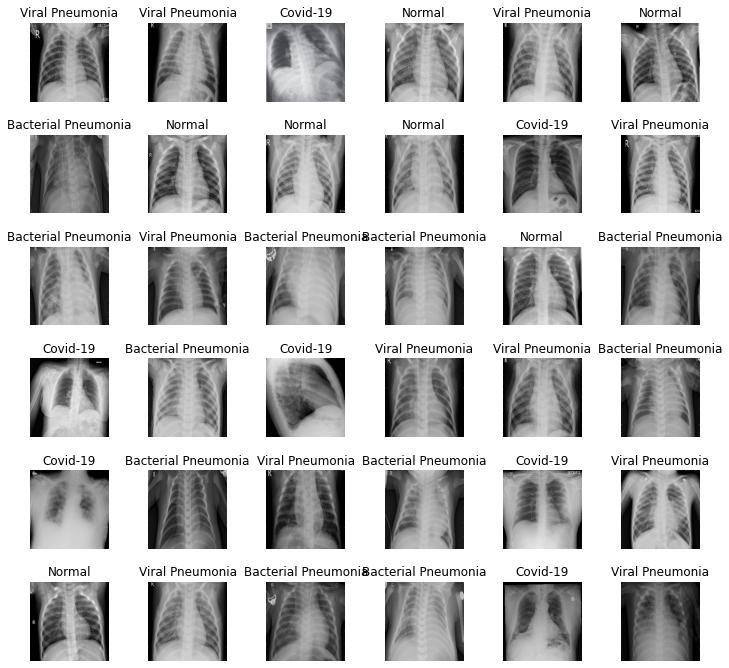

In [24]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_name[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# TASK #4: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [25]:
basemodel = ResNet50(weights='imagenet', include_top=False,
    input_tensor=Input(shape=(256, 256, 3)))

2022-07-18 00:33:30.780767: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 00:33:31.407420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6888 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:e5:00.0, compute capability: 7.0


94781440/94765736 [==============================] - 8s 0us/step


In [26]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [27]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
    layers.trainable = False

# TASK #5: BUILD AND TRAIN DEEP LEARNING MODEL

In [28]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

In [29]:
model = Model(inputs=basemodel.input, outputs=headmodel)

In [30]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4, decay=1e-6), metrics=["accuracy"])

In [31]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [32]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory=X_Ray_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory=X_Ray_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [33]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/10


2022-07-18 00:34:08.626381: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8303


107/107 [==============================] - ETA: 0s - loss: 0.9180 - accuracy: 0.6776
Epoch 00001: val_loss improved from inf to 8.00732, saving model to weights.hdf5


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


107/107 [==============================] - 42s 137ms/step - loss: 0.9180 - accuracy: 0.6776 - val_loss: 8.0073 - val_accuracy: 0.2500
Epoch 2/10
106/107 [============================>.] - ETA: 0s - loss: 0.5435 - accuracy: 0.8137
Epoch 00002: val_loss did not improve from 8.00732
107/107 [==============================] - 8s 72ms/step - loss: 0.5398 - accuracy: 0.8154 - val_loss: 15.7769 - val_accuracy: 0.2500
Epoch 3/10
106/107 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9198
Epoch 00003: val_loss did not improve from 8.00732
107/107 [==============================] - 8s 74ms/step - loss: 0.2604 - accuracy: 0.9182 - val_loss: 9.3631 - val_accuracy: 0.2500
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9509
Epoch 00004: val_loss did not improve from 8.00732
107/107 [==============================] - 8s 73ms/step - loss: 0.1467 - accuracy: 0.9509 - val_loss: 14.0256 - val_accuracy: 0.2500
Epoch 5/10
107/107 [=======

# TASK #6: EVALUATE TRAINED DEEP LEARNING MODEL

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

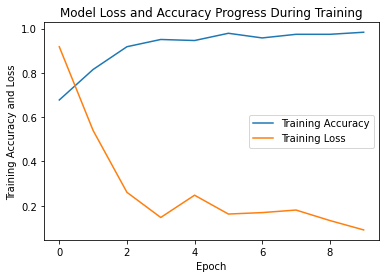

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

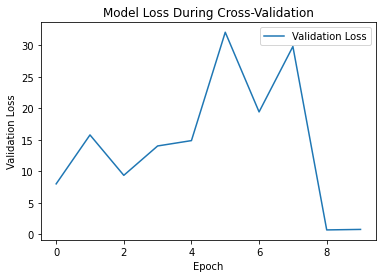

In [39]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

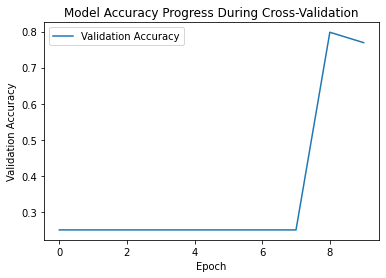

In [40]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [41]:
test_directory = 'data/Test'

In [43]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 [==============================] - 1s 3ms/step - loss: 2.0871 - accuracy: 0.6500
Accuracy Test : 0.6499999761581421


In [45]:
len(original)

40

In [46]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7


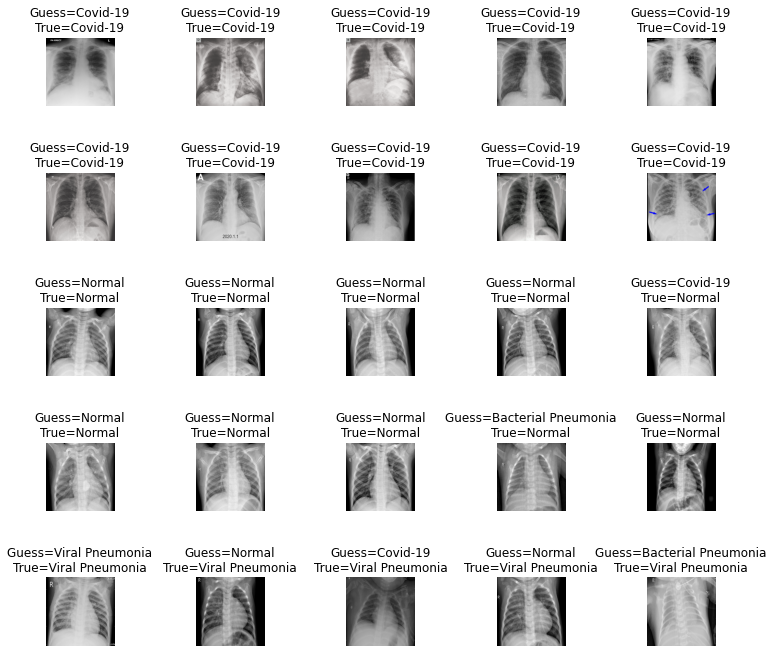

In [49]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_name[prediction[i]]), str(label_name[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.83      1.00      0.91        10
           2       1.00      0.50      0.67        10
           3       0.82      0.90      0.86        10

    accuracy                           0.85        40
   macro avg       0.87      0.85      0.84        40
weighted avg       0.87      0.85      0.84        40



Text(0.5, 1.0, 'Confusion_matrix')

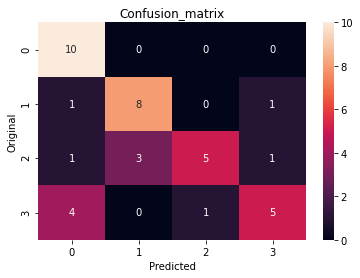

In [50]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')